In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# 1.Data Collection
stock_symbol = 'AAPL'
data = yf.download(stock_symbol, start="2015-01-01", end="2025-01-01")
data.reset_index(inplace=True)

/tmp/ipython-input-2989628885.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock_symbol, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


In [3]:
# 2.Data Preprocessing
data = data[['Date', 'Close']]
data = data.dropna()
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


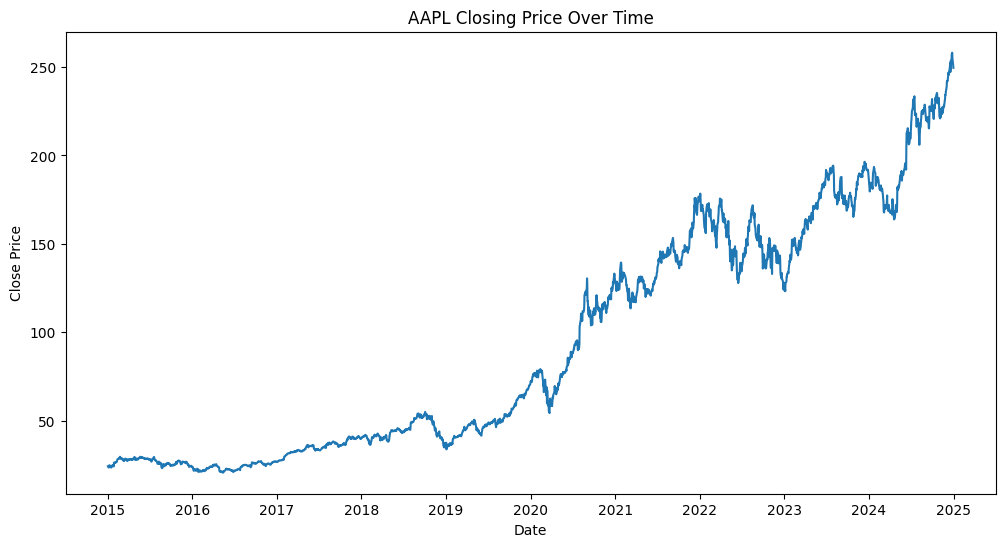

In [4]:
# 3.Visualization
plt.figure(figsize=(12,6))
plt.plot(data['Close'])
plt.title(f'{stock_symbol} Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [5]:
# 4.ARIMA Model
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

arima_model = ARIMA(train['Close'], order=(5,1,0))
arima_result = arima_model.fit()

arima_forecast = arima_result.forecast(steps=len(test))

arima_rmse = np.sqrt(mean_squared_error(test['Close'], arima_forecast))
print(f'ARIMA RMSE: {arima_rmse}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA RMSE: 69.69171531324085


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [6]:
# 5.SARIMA Model
sarima_model = SARIMAX(train['Close'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit()

sarima_forecast = sarima_result.forecast(steps=len(test))
sarima_rmse = np.sqrt(mean_squared_error(test['Close'], sarima_forecast))
print(f'SARIMA RMSE: {sarima_rmse}')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA RMSE: 55.22789081525389


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [8]:
# Step 1: Inspect your data
print("Original data columns:", data.columns)
print(data.head())


Original data columns: MultiIndex([('Close', 'AAPL')],
           names=['Price', 'Ticker'])
Price           Close
Ticker           AAPL
Date                 
2015-01-02  24.261047
2015-01-05  23.577570
2015-01-06  23.579800
2015-01-07  23.910437
2015-01-08  24.829126


In [9]:
print("==== Columns in 'data' ====")
print(data.columns)
print("\n==== Sample 'data' ====")
print(data.head())

print("\n==== Is the index named? ====")
print(data.index.name)


==== Columns in 'data' ====
MultiIndex([('Close', 'AAPL')],
           names=['Price', 'Ticker'])

==== Sample 'data' ====
Price           Close
Ticker           AAPL
Date                 
2015-01-02  24.261047
2015-01-05  23.577570
2015-01-06  23.579800
2015-01-07  23.910437
2015-01-08  24.829126

==== Is the index named? ====
Date


In [10]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

#Flatten the MultiIndex column
flat_data = data.copy()
flat_data.columns = ['Close']  # rename ('Close', 'AAPL') → 'Close'

#Reset the index to make 'Date' a column
prophet_df = flat_data.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})

#Confirm
print(prophet_df.head())
print(prophet_df.columns)

#Ensure correct datatypes
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
prophet_df['y'] = pd.to_numeric(prophet_df['y'], errors='coerce')
prophet_df = prophet_df.dropna(subset=['y'])

#Split the data
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

#Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

#Make future dataframe and forecast
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast_prophet = prophet_model.predict(future)

#Calculate RMSE
predicted = forecast_prophet['yhat'].iloc[-len(test_prophet):]
actual = test_prophet['y']
prophet_rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f'✅ Prophet RMSE: {prophet_rmse}')


          ds          y
0 2015-01-02  24.261047
1 2015-01-05  23.577570
2 2015-01-06  23.579800
3 2015-01-07  23.910437
4 2015-01-08  24.829126
Index(['ds', 'y'], dtype='object')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn0d3ptja/c15rfkaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn0d3ptja/ey7q69uu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10210', 'data', 'file=/tmp/tmpn0d3ptja/c15rfkaq.json', 'init=/tmp/tmpn0d3ptja/ey7q69uu.json', 'output', 'file=/tmp/tmpn0d3ptja/prophet_modellken67gz/prophet_model-20250812094829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:48:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:48:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet RMSE: 38.91635951124175


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

train_size_lstm = int(X.shape[0] * 0.8)
X_train, X_test = X[:train_size_lstm], X[train_size_lstm:]
y_train, y_test = y[:train_size_lstm], y[train_size_lstm:]

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, batch_size=32, epochs=10)

predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
print(f'LSTM RMSE: {lstm_rmse}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0192
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.7491e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - loss: 3.0589e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 2.8903e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 2.5997e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 2.6732e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.8032e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 2.5638e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 2.1508e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.8843e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
LSTM RMSE: 6.624923622319765


In [12]:
rmse_results = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'LSTM'],
    'RMSE': [arima_rmse, sarima_rmse, prophet_rmse, lstm_rmse]
})
print("\nModel Comparison:")
print(rmse_results)


Model Comparison:
     Model       RMSE
0    ARIMA  69.691715
1   SARIMA  55.227891
2  Prophet  38.916360
3     LSTM   6.624924


In [13]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

#Flatten MultiIndex column from ('Close', 'AAPL') to 'Close'
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['Close']  # Only if you have one stock column
else:
    data.rename(columns={'Close': 'Close'}, inplace=True)

#Create the Prophet dataframe
prophet_df = pd.DataFrame({
    'ds': data.index,
    'y': pd.to_numeric(data['Close'], errors='coerce')
}).dropna()

#Split into train/test
train_size = int(len(prophet_df) * 0.8)
train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

#Train Prophet model
prophet_model = Prophet()
prophet_model.fit(train_prophet)

#Forecast
future = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast_prophet = prophet_model.predict(future)

#Evaluate
y_true = test_prophet['y'].values
y_pred = forecast_prophet['yhat'].iloc[-len(test_prophet):].values
prophet_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f" Prophet RMSE: {prophet_rmse}")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn0d3ptja/j2w8pfu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn0d3ptja/9bfyjhhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93496', 'data', 'file=/tmp/tmpn0d3ptja/j2w8pfu0.json', 'init=/tmp/tmpn0d3ptja/9bfyjhhz.json', 'output', 'file=/tmp/tmpn0d3ptja/prophet_modelvv1h60kt/prophet_model-20250812094928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:49:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


 Prophet RMSE: 38.91635951124175


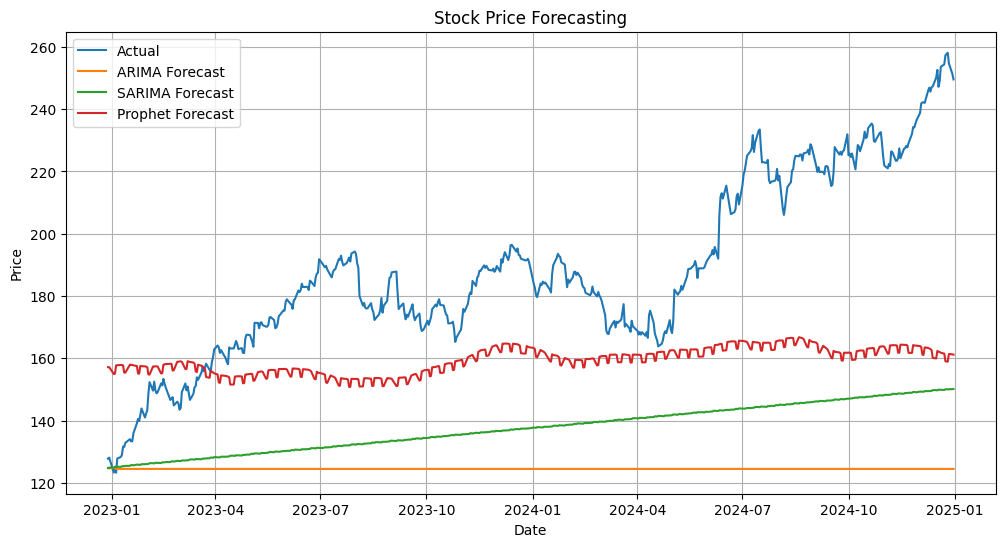

In [18]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.plot(test.index, forecast_prophet['yhat'].iloc[-len(test):].values, label='Prophet Forecast')
plt.legend()
plt.title('Stock Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()


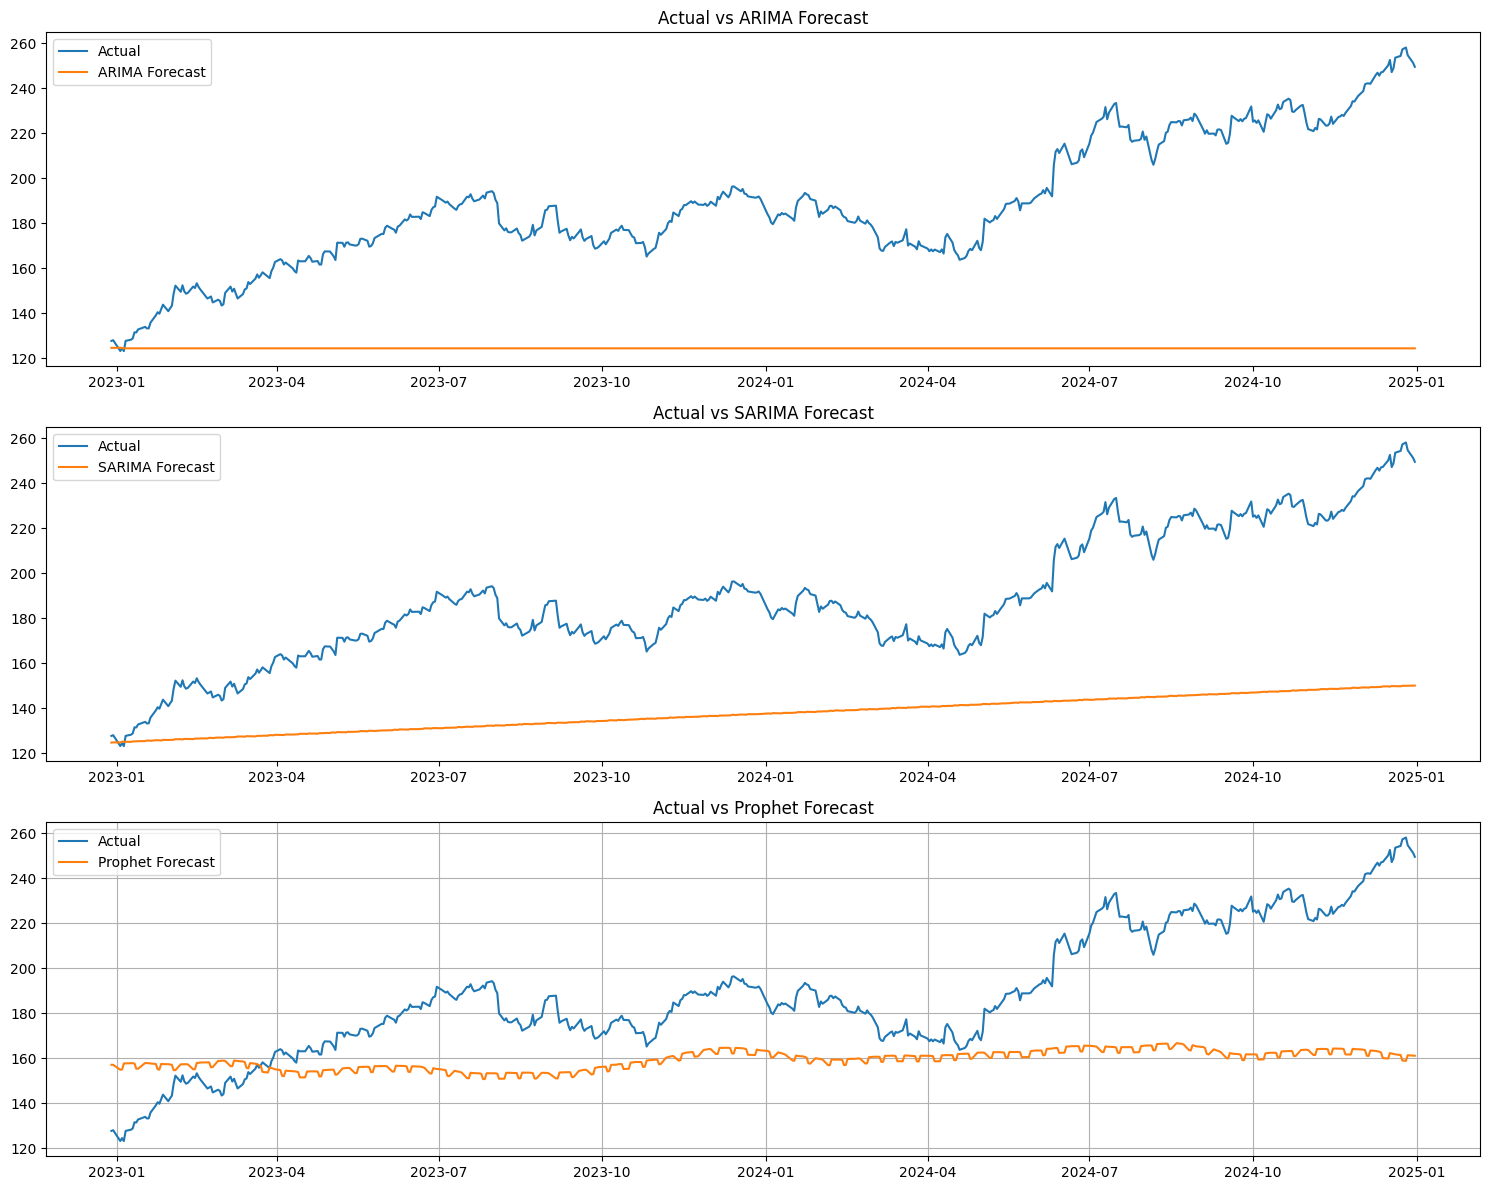

In [16]:
plt.figure(figsize=(15, 12))

#Actual vs ARIMA
plt.subplot(3, 1, 1)
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('Actual vs ARIMA Forecast')
plt.legend()

#Actual vs SARIMA
plt.subplot(3, 1, 2)
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.title('Actual vs SARIMA Forecast')
plt.legend()

#Actual vs Prophet
plt.subplot(3, 1, 3)
plt.plot(test.index, test['Close'], label='Actual')
plt.plot(test.index, forecast_prophet['yhat'].iloc[-len(test):].values, label='Prophet Forecast')
plt.title('Actual vs Prophet Forecast')
plt.legend()

plt.tight_layout()
plt.grid()
plt.show()
